# Predicting Nutrient Gaps: Amini Soil LightGBM (Extensive Feature Engineering with Target Scaling (log1p))¶

Well this is the third notebook. I know you guys are tired, so am I 😪. But hang in there, it will only take a moment. 👌😜

## 📦 Importing Required Packages
This section imports all necessary libraries for data processing, visualization, modeling, and evaluation. It includes tools for:

1. Data handling: pandas, numpy

2. Visualization: matplotlib, seaborn

3. Preprocessing and evaluation: scikit-learn (scaling, splitting, cross-validation, metrics)

4. Modeling: LightGBM for gradient boosting

5. Utilities: os, statistics, and warnings for environment control and cleaner output

In [1]:
# IMPORT ALL PACKAGES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import os
import statistics
import warnings

# Suppress Warnings
warnings.filterwarnings('ignore')

In [2]:
# This is to view all columns

pd.set_option("display.max_columns", None)

## 📥 Load Soil Prediction Challenge Data
The function below loads all the required datasets for the Amini Soil Prediction Challenge from a specified directory. It reads in the training, test, and gap-filled datasets, along with satellite (LANDSAT8) data and the sample submission file.

🔧 Function: <code>load_soil_prediction_data</code>

Parameter:

<code>base_path</code> (str): Path to the dataset directory (default: Kaggle input folder path).

Returns:

A dictionary containing the following DataFrames:

<code>train</code>: Training features and targets

<code>test</code>: Test features

<code>train_gap</code>: Contains Gap Information of Train set

<code>test_gap</code>: Contains Gap Information of Test set

<code>sample_submission</code>: Submission template

<code>landsat8_data</code>: Remote sensing data (LANDSAT 8)

In [3]:
def load_soil_prediction_data(base_path='/kaggle/input/amini-soil-prediction-challenge-dataset'):
    """
    Loads all required datasets for the Amini Soil Prediction Challenge.

    Parameters:
    - base_path (str): Path to the dataset directory.

    Returns:
    - dict: A dictionary containing all loaded DataFrames.
    """
    train_df = pd.read_csv(f'{base_path}/Train.csv')
    test_df = pd.read_csv(f'{base_path}/Test.csv')
    train_gap_df = pd.read_csv(f'{base_path}/Gap_Train.csv')
    test_gap_df = pd.read_csv(f'{base_path}/Gap_Test.csv')
    sample_submission = pd.read_csv(f'{base_path}/SampleSubmission.csv')
    landsat8_data = pd.read_csv(f'{base_path}/LANDSAT8_data_updated.csv')
    
    return {
        "train": train_df,
        "test": test_df,
        "train_gap": train_gap_df,
        "test_gap": test_gap_df,
        "sample_submission": sample_submission,
        "landsat8_data": landsat8_data
    }


In [4]:
data = load_soil_prediction_data()
train_df = data["train"]
test_df = data["test"]
train_gap_df = data['train_gap']
test_gap_df = data['test_gap']
landsat8_data = data['landsat8_data']

## We can skip exploration since they are in the previous notebooks😪

In [5]:
test_gap_df = pd.merge(test_gap_df, test_df[['PID', 'BulkDensity']], on='PID', how='left')

In [6]:
test_gap_df.head()

,Nutrient,Required,PID,BulkDensity
0,N,100.0,ID_NGS9Bx,1.2
1,P,40.0,ID_NGS9Bx,1.2
2,K,52.0,ID_NGS9Bx,1.2
3,Ca,12.0,ID_NGS9Bx,1.2
4,Mg,8.0,ID_NGS9Bx,1.2


Let's assign the target variables

In [7]:
target_columns = ['N', 'P', 'K', 'Ca', 'Mg', 'S', 'Fe', 'Mn', 'Zn', 'Cu', 'B']

In [8]:
# Drop target features to only get the train features for modelling.

train_fe = train_df.drop(columns=target_columns)

## 📐 Add Site-Level Statistical Features

This function enhances the dataset by computing site-level summary statistics (min, max, mean, median) for numeric columns and merging them back into the original DataFrame. This technique helps capture broader spatial patterns tied to each site.

🔧 Function: <code>add_site_level_statistics</code>
Parameters:

<code>df</code> (pd.DataFrame): The input DataFrame to enrich.

<code>group_col</code> (str): The column used to group data (default: 'site').

<code>exclude_cols</code> (list or None): List of columns to exclude from aggregation (defaults to <code>['PID', 'lon', 'lat', 'site']</code>).

Returns:

A new DataFrame with original columns plus appended site-level statistical features.

In [9]:
def add_site_level_statistics(df, group_col='site', exclude_cols=None):
    """
    Computes site-level statistics and merges them back to the original dataframe.

    Parameters:
    - df (pd.DataFrame): Input DataFrame to aggregate.
    - group_col (str): Column name to group by (default is 'site').
    - exclude_cols (list): Columns to exclude from aggregation (default includes ['PID', 'lon', 'lat', 'site']).

    Returns:
    - pd.DataFrame: DataFrame with site-level statistics merged.
    """
    if exclude_cols is None:
        exclude_cols = ['PID', 'lon', 'lat', group_col]

    # Select numeric columns for aggregation
    agg_cols = [col for col in df.columns if col not in exclude_cols and pd.api.types.is_numeric_dtype(df[col])]

    # Compute group-level statistics
    site_stats = df.groupby(group_col)[agg_cols].agg(['min', 'max', 'mean', 'median'])

    # Flatten column names
    site_stats.columns = ['_'.join(col).strip() for col in site_stats.columns.values]

    # Reset index to prepare for merging
    site_stats.reset_index(inplace=True)

    # Merge statistics back into the original dataframe
    df_merged = df.merge(site_stats, on=group_col, how='left')

    return df_merged

In [10]:
train_fe = add_site_level_statistics(train_fe)
test_df = add_site_level_statistics(test_df)

In [11]:
train_fe.head()

,site,PID,lon,lat,pH,alb,bio1,bio12,bio15,bio7,bp,cec20,dows,ecec20,hp20,ls,lstd,lstn,mb1,mb2,mb3,mb7,mdem,para,parv,ph20,slope,snd20,soc20,tim,wp,xhp20,BulkDensity,pH_min,pH_max,pH_mean,pH_median,alb_min,alb_max,alb_mean,alb_median,bio1_min,bio1_max,bio1_mean,bio1_median,bio12_min,bio12_max,bio12_mean,bio12_median,bio15_min,bio15_max,bio15_mean,bio15_median,bio7_min,bio7_max,bio7_mean,bio7_median,bp_min,bp_max,bp_mean,bp_median,cec20_min,cec20_max,cec20_mean,cec20_median,dows_min,dows_max,dows_mean,dows_median,ecec20_min,ecec20_max,ecec20_mean,ecec20_median,hp20_min,hp20_max,hp20_mean,hp20_median,ls_min,ls_max,ls_mean,ls_median,lstd_min,lstd_max,lstd_mean,lstd_median,lstn_min,lstn_max,lstn_mean,lstn_median,mb1_min,mb1_max,mb1_mean,mb1_median,mb2_min,mb2_max,mb2_mean,mb2_median,mb3_min,mb3_max,mb3_mean,mb3_median,mb7_min,mb7_max,mb7_mean,mb7_median,mdem_min,mdem_max,mdem_mean,mdem_median,para_min,para_max,para_mean,para_median,parv_min,parv_max,parv_mean,parv_median,ph20_min,ph20_max,ph20_mean,ph20_median,slope_min,slope_max,slope_mean,slope_median,snd20_min,snd20_max,snd20_mean,snd20_median,soc20_min,soc20_max,soc20_mean,soc20_median,tim_min,tim_max,tim_mean,tim_median,wp_min,wp_max,wp_mean,wp_median,xhp20_min,xhp20_max,xhp20_mean,xhp20_median,BulkDensity_min,BulkDensity_max,BulkDensity_mean,BulkDensity_median
0,site_id_bIEHwl,ID_I5RGjv,70.603761,46.173798,7.75,176,248,920,108,190,0.581573,22.00,21.500278,11.007790,0.00779,0.030000,44.908058,18.967873,2006.000488,3182.000732,855.000244,2363.000732,1097,20.544283,126.835480,7.050,1.962921,39.00,9.75,7.962668,0.016853,0.000708,1.46,6.40,7.75,7.185,7.195,132,176,156.875000,167.0,247,249,248.000000,248.0,912,1018,955.250000,950.0,108,110,108.375000,108.0,190,191,190.25,190.0,0.058747,0.707932,0.353755,0.373809,22.00,33.25,29.468750,30.50,21.424564,23.590298,22.401946,22.366915,11.00779,25.231001,18.853312,17.048150,0.00000,0.2390,0.103311,0.04815,0.03,0.094082,0.045196,0.03,44.240669,46.608509,45.435076,45.488026,18.465033,19.427130,18.949129,18.940107,864.000427,2006.000488,1320.500130,1405.500061,1645.000732,3182.000732,2351.375214,2576.499878,464.000092,855.000244,599.500076,612.500031,1306.000122,2363.000732,1826.625031,1972.999939,1081,1097,1089.750000,1089.5,19.412239,24.103060,22.205113,22.318841,110.758514,243.023132,167.595243,135.761497,6.975,7.425,7.146875,7.050,0.447508,2.035072,1.009586,0.761513,31.50,43.00,37.843750,40.0,8.0,11.75,9.468750,9.125,7.962668,13.112203,10.245096,10.072555,0.016538,0.019393,0.017339,0.017097,0.000000,0.010284,0.004563,0.002838,1.38,1.47,1.447500,1.46
1,site_id_nGvnKc,ID_8jWzJ5,70.590479,46.078924,7.10,181,250,1080,113,191,0.707011,24.00,21.389599,14.023500,0.02350,0.030000,44.985626,19.730261,1637.000122,2839.000488,707.000061,2039.000488,1060,18.869566,109.835541,6.975,0.162065,40.00,8.00,8.439500,0.018321,0.001676,1.52,6.26,8.00,7.220,7.100,145,196,173.428571,174.0,249,252,250.285714,250.0,1008,1149,1086.857143,1109.0,110,113,111.428571,111.0,191,191,191.00,191.0,0.061296,0.707011,0.371490,0.362439,14.25,34.00,22.892857,23.75,17.022963,23.510744,19.944179,19.404194,14.02350,40.185001,21.082966,17.169001,0.00596,0.1850,0.082966,0.06240,0.03,0.110223,0.051956,0.03,42.409557,44.985626,43.842627,44.167717,18.270815,19.730261,19.220232,19.413284,966.999878,1642.000000,1372.999930,1382.999634,2046.999756,2910.000000,2557.714355,2531.999756,473.000061,772.999939,641.857143,631.999939,1309.000122,2107.999756,1842.285836,1961.000000,1022,1077,1051.857143,1049.0,18.869566,32.342995,25.213711,24.719807,109.835541,417.613312,234.243402,214.385269,6.625,7.025,6.782143,6.725,0.162065,2.499955,0.886719,0.708708,27.25,46.00,39.678571,43.5,8.0,10.75,9.321429,9.250,7.365927,12.241879,9.893438,8.666523,0.016913,0.020588,0.018852,0.018339,0.000372,0.009843,0.003725,0.003885,1.36,1.52,1.454286,1.48
2,site_id_nGvnKc,ID_UgzkN8,70.582553,46.048820,6.95,188,250,1109,111,191,0.362439,15.25,18.900057,16.062401,0.06240,0.030000,44.167717,19.413284,1639.999634,2903

In [12]:
test_df.head()

,site,PID,lon,lat,pH,alb,bio1,bio12,bio15,bio7,bp,cec20,dows,ecec20,hp20,ls,lstd,lstn,mb1,mb2,mb3,mb7,mdem,para,parv,ph20,slope,snd20,soc20,tim,wp,xhp20,BulkDensity,pH_min,pH_max,pH_mean,pH_median,alb_min,alb_max,alb_mean,alb_median,bio1_min,bio1_max,bio1_mean,bio1_median,bio12_min,bio12_max,bio12_mean,bio12_median,bio15_min,bio15_max,bio15_mean,bio15_median,bio7_min,bio7_max,bio7_mean,bio7_median,bp_min,bp_max,bp_mean,bp_median,cec20_min,cec20_max,cec20_mean,cec20_median,dows_min,dows_max,dows_mean,dows_median,ecec20_min,ecec20_max,ecec20_mean,ecec20_median,hp20_min,hp20_max,hp20_mean,hp20_median,ls_min,ls_max,ls_mean,ls_median,lstd_min,lstd_max,lstd_mean,lstd_median,lstn_min,lstn_max,lstn_mean,lstn_median,mb1_min,mb1_max,mb1_mean,mb1_median,mb2_min,mb2_max,mb2_mean,mb2_median,mb3_min,mb3_max,mb3_mean,mb3_median,mb7_min,mb7_max,mb7_mean,mb7_median,mdem_min,mdem_max,mdem_mean,mdem_median,para_min,para_max,para_mean,para_median,parv_min,parv_max,parv_mean,parv_median,ph20_min,ph20_max,ph20_mean,ph20_median,slope_min,slope_max,slope_mean,slope_median,snd20_min,snd20_max,snd20_mean,snd20_median,soc20_min,soc20_max,soc20_mean,soc20_median,tim_min,tim_max,tim_mean,tim_median,wp_min,wp_max,wp_mean,wp_median,xhp20_min,xhp20_max,xhp20_mean,xhp20_median,BulkDensity_min,BulkDensity_max,BulkDensity_mean,BulkDensity_median
0,site_id_hgJpkz,ID_NGS9Bx,69.170794,44.522885,6.86,144,256,910,108,186,0.038132,44.75,1.581062,17.099701,0.0997,0.03,40.674942,18.333445,991.000061,2484.000488,486.000031,1413.000244,817,37.940418,467.619293,6.825,1.056416,25.50,15.25,8.732471,0.016981,0.005831,1.20,6.86,7.27,7.125000,7.185,139,144,141.500000,141.5,252,256,254.000000,254.0,910,1142,1021.500000,1017.0,108,110,109.000000,109.0,185,186,185.75,186.0,0.034111,0.071103,0.050398,0.048190,42.25,52.0,46.625,46.125,1.457660,5.482658,2.882902,2.295646,17.015301,21.152000,18.330776,17.577901,0.0153,0.152,0.080775,0.0779,0.03,0.030000,0.030000,0.030000,39.160236,40.674942,39.811288,39.704987,18.007334,18.333445,18.228101,18.285812,825.999939,991.000061,891.500000,874.500000,2374.000244,2484.000488,2428.000427,2427.000488,407.000000,486.000031,449.000015,451.500015,1238.000000,1413.000244,1322.250061,1319.000000,817,870,837.250000,831.0,37.940418,42.647343,40.499194,40.704508,404.839844,472.334045,440.700142,442.813339,6.725,6.825,6.768750,6.7625,0.962974,1.433321,1.108144,1.018141,22.00,26.00,24.375000,24.75,15.25,18.00,17.187500,17.75,8.732471,11.439353,10.057749,10.029587,0.016981,0.035683,0.026470,0.026608,0.000899,0.007186,0.004256,0.004469,1.20,1.25,1.2275,1.23
1,site_id_olmuI5,ID_YdVKXw,68.885265,44.741057,7.08,129,260,851,110,187,0.040187,53.00,5.700576,25.129000,0.1290,0.03,41.836205,18.762138,819.000000,2257.000000,412.000000,1199.000122,759,35.961353,542.590149,6.725,0.730379,18.75,14.00,10.565657,0.021030,0.005134,1.24,7.08,7.74,7.343333,7.210,129,131,129.666667,129.0,260,261,260.666667,261.0,841,851,846.333333,847.0,110,111,110.666667,111.0,187,187,187.00,187.0,0.040187,0.075281,0.053398,0.044726,53.00,60.0,56.000,55.000,4.160606,5.700576,4.889923,4.808586,25.129000,42.051498,34.082666,35.067501,0.0515,0.129,0.082667,0.0675,0.03,0.071170,0.043723,0.030000,41.836205,42.037308,41.922905,41.895203,18.762138,18.844263,18.810220,18.824259,819.000000,933.999695,860.999837,829.999817,2178.999512,2257.000000,2216.333089,2212.999756,412.000000,438.999969,425.333303,424.999939,1199.000122,1232.000000,1216.333333,1217.999878,748,759,751.666667,748.0,34.267311,35.961353,35.396673,35.961353,434.518616,542.590149,506.566305,542.590149,6.725,6.900,6.816667,6.8250,0.707549,1.069535,0.835821,0.730379,18.25,19.00,18.666667,18.75,11.75,14.00,12.833333,12.75,9.133697,12.951569,10.883641,10.565657,0.021030,0.024179,0.022297,0.021681,0.001225,0.005134,0.002761,0.001925,1.24,1.30,1.2600,1.24
2,site_id_PTZdJz,ID_MZAlfE,68.970210,44.675777,6.50,142,259,901,109,187,0.068795,49.00,6.823292,26.117001,0.1170,0.03,42.058319,18.344410,965.000000,2378.000244,444.999969,1324.000000,769

## 🛰️ Merge Aggregated LANDSAT8 Features
This function enriches both the training and test datasets by aggregating LANDSAT8 satellite spectral features at the PID level and merging the aggregated statistics into the main DataFrames.

🔧 Function: <code>merge_landsat8_aggregates</code>
Parameters:

<code>train_df</code> (pd.DataFrame): The original training dataset.

<code>test_df</code> (pd.DataFrame): The original test dataset.

<code>landsat8_data</code> (pd.DataFrame): Raw LANDSAT8 data containing spectral bands per PID.

<code>pid_col</code> (str): Identifier column used for grouping (default: 'PID').

Returns:

A tuple of two DataFrames: <code>(train_df_merged, test_df_merged)</code> — both augmented with LANDSAT8 statistical features.

Aggregated Features:

Stats computed per PID: <code>mean</code>, <code>std</code>, <code>min</code>, and <code>max</code>

Columns aggregated include:
<code>'QA_PIXEL'</code>, <code>'QA_RADSAT'</code>, <code>'SR_B1'</code> through <code>'SR_B7'</code>, and <code>'ST_B10'</code>

In [13]:
def merge_landsat8_aggregates(train_df, test_df, landsat8_data, pid_col='PID'):
    """
    Aggregates Landsat8 data by PID and merges the aggregated features with train and test DataFrames.

    Parameters:
    - train_df (pd.DataFrame): Training dataframe to merge with Landsat8 features.
    - test_df (pd.DataFrame): Test dataframe to merge with Landsat8 features.
    - landsat8_data (pd.DataFrame): Landsat8 raw data containing 'PID' and spectral bands.
    - pid_col (str): Column to group by (default is 'PID').

    Returns:
    - (pd.DataFrame, pd.DataFrame): Tuple of (train_df_merged, test_df_merged)
    """
    # Define numeric columns for aggregation
    landsat_numeric_cols = [
        'QA_PIXEL', 'QA_RADSAT', 'SR_B1', 'SR_B2', 'SR_B3',
        'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10'
    ]

    # Aggregate with multiple statistics
    landsat8_agg = landsat8_data.groupby(pid_col)[landsat_numeric_cols].agg(['mean', 'std', 'min', 'max']).reset_index()

    # Flatten multi-level column names
    landsat8_agg.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in landsat8_agg.columns.values]

    # Merge with train and test data
    train_merged = train_df.merge(landsat8_agg, on=pid_col, how='left')
    test_merged = test_df.merge(landsat8_agg, on=pid_col, how='left')

    return train_merged, test_merged

In [14]:
train_fe, test_df = merge_landsat8_aggregates(train_fe, test_df, landsat8_data)

In [15]:
train_fe

,site,PID,lon,lat,pH,alb,bio1,bio12,bio15,bio7,bp,cec20,dows,ecec20,hp20,ls,lstd,lstn,mb1,mb2,mb3,mb7,mdem,para,parv,ph20,slope,snd20,soc20,tim,wp,xhp20,BulkDensity,pH_min,pH_max,pH_mean,pH_median,alb_min,alb_max,alb_mean,alb_median,bio1_min,bio1_max,bio1_mean,bio1_median,bio12_min,bio12_max,bio12_mean,bio12_median,bio15_min,bio15_max,bio15_mean,bio15_median,bio7_min,bio7_max,bio7_mean,bio7_median,bp_min,bp_max,bp_mean,bp_median,cec20_min,cec20_max,cec20_mean,cec20_median,dows_min,dows_max,dows_mean,dows_median,ecec20_min,ecec20_max,ecec20_mean,ecec20_median,hp20_min,hp20_max,hp20_mean,hp20_median,ls_min,ls_max,ls_mean,ls_median,lstd_min,lstd_max,lstd_mean,lstd_median,lstn_min,lstn_max,lstn_mean,lstn_median,mb1_min,mb1_max,mb1_mean,mb1_median,mb2_min,mb2_max,mb2_mean,mb2_median,mb3_min,mb3_max,mb3_mean,mb3_median,mb7_min,mb7_max,mb7_mean,mb7_median,mdem_min,mdem_max,mdem_mean,mdem_median,para_min,para_max,para_mean,para_median,parv_min,parv_max,parv_mean,parv_median,ph20_min,ph20_max,ph20_mean,ph20_median,slope_min,slope_max,slope_mean,slope_median,snd20_min,snd20_max,snd20_mean,snd20_median,soc20_min,soc20_max,soc20_mean,soc20_median,tim_min,tim_max,tim_mean,tim_median,wp_min,wp_max,wp_mean,wp_median,xhp20_min,xhp20_max,xhp20_mean,xhp20_median,BulkDensity_min,BulkDensity_max,BulkDensity_mean,BulkDensity_median,QA_PIXEL_mean,QA_PIXEL_std,QA_PIXEL_min,QA_PIXEL_max,QA_RADSAT_mean,QA_RADSAT_std,QA_RADSAT_min,QA_RADSAT_max,SR_B1_mean,SR_B1_std,SR_B1_min,SR_B1_max,SR_B2_mean,SR_B2_std,SR_B2_min,SR_B2_max,SR_B3_mean,SR_B3_std,SR_B3_min,SR_B3_max,SR_B4_mean,SR_B4_std,SR_B4_min,SR_B4_max,SR_B5_mean,SR_B5_std,SR_B5_min,SR_B5_max,SR_B6_mean,SR_B6_std,SR_B6_min,SR_B6_max,SR_B7_mean,SR_B7_std,SR_B7_min,SR_B7_max,ST_B10_mean,ST_B10_std,ST_B10_min,ST_B10_max
0,site_id_bIEHwl,ID_I5RGjv,70.603761,46.173798,7.75,176,248,920,108,190,0.581573,22.00,21.500278,11.007790,0.00779,0.030000,44.908058,18.967873,2006.000488,3182.000732,855.000244,2363.000732,1097,20.544283,126.835480,7.050,1.962921,39.00,9.75,7.962668,0.016853,0.000708,1.46,6.40,7.75,7.185000,7.195,132,176,156.875000,167.0,247,249,248.000000,248.0,912,1018,955.250000,950.0,108,110,108.375000,108.0,190,191,190.250000,190.0,0.058747,0.707932,0.353755,0.373809,22.00,33.25,29.468750,30.500,21.424564,23.590298,22.401946,22.366915,11.00779,25.231001,18.853312,17.048150,0.00000,0.2390,0.103311,0.04815,0.03,0.094082,0.045196,0.03,44.240669,46.608509,45.435076,45.488026,18.465033,19.427130,18.949129,18.940107,864.000427,2006.000488,1320.500130,1405.500061,1645.000732,3182.000732,2351.375214,2576.499878,464.000092,855.000244,599.500076,612.500031,1306.000122,2363.000732,1826.625031,1972.999939,1081,1097,1089.750000,1089.5,19.412239,24.103060,22.205113,22.318841,110.758514,243.023132,167.595243,135.761497,6.975,7.425,7.146875,7.050,0.447508,2.035072,1.009586,0.761513,31.50,43.00,37.843750,40.000,8.00,11.75,9.468750,9.125,7.962668,13.112203,10.245096,10.072555,0.016538,0.019393,0.017339,0.017097,0.000000,0.010284,0.004563,0.002838,1.38,1.47,1.447500,1.460,23361.253731,6890.266312,21824.0,55052.0,0.0,0.0,0.0,0.0,0.106083,0.159315,0.021100,0.777405,0.128771,0.153452,0.038837,0.766268,0.184369,0.133760,0.085065,0.746110,0.229442,0.124249,0.095598,0.735770,0.356474,0.099793,0.179940,0.779550,0.374687,0.075534,0.161102,0.641610,0.237561,0.066450,0.101592,0.516650,1.076409,0.220386,-0.191942,1.265640
1,site_id_nGvnKc,ID_8jWzJ5,70.590479,46.078924,7.10,181,250,1080,113,191,0.707011,24.00,21.389599,14.023500,0.02350,0.030000,44.985626,19.730261,1637.000122,2839.000488,707.000061,2039.000488,1060,18.869566,109.835541,6.975,0.162065,40.00,8.00,8.439500,0.018321,0.001676,1.52,6.26,8.00,7.220000,7.100,145,196,173.428571,174.0,249,252,250.285714,250.0,1008,1149,1086.857143,1109.0,110,113,111.428571,111.0,191,191,191.000000,191.0,0.061296,0.707011,0.371490,0.362439,14.25,34.00,22.892857,23.750,17.022963,23.510744,19.944179,19.404194,14.02350,40.185001,21.082966,17.169001,0.00596,0.1850,0.082966,0.06240,0.03,0.11

In [16]:
train_fe.isnull().sum().sort_values()

site           0
mb3_min        0
mb3_max        0
mb3_mean       0
mb3_median     0
              ..
ST_B10_max     3
BulkDensity    4
ecec20         5
hp20           5
xhp20          5
Length: 189, dtype: int64

In [17]:
train_fe.describe()

,lon,lat,pH,alb,bio1,bio12,bio15,bio7,bp,cec20,dows,ecec20,hp20,ls,lstd,lstn,mb1,mb2,mb3,mb7,mdem,para,parv,ph20,slope,snd20,soc20,tim,wp,xhp20,BulkDensity,pH_min,pH_max,pH_mean,pH_median,alb_min,alb_max,alb_mean,alb_median,bio1_min,bio1_max,bio1_mean,bio1_median,bio12_min,bio12_max,bio12_mean,bio12_median,bio15_min,bio15_max,bio15_mean,bio15_median,bio7_min,bio7_max,bio7_mean,bio7_median,bp_min,bp_max,bp_mean,bp_median,cec20_min,cec20_max,cec20_mean,cec20_median,dows_min,dows_max,dows_mean,dows_median,ecec20_min,ecec20_max,ecec20_mean,ecec20_median,hp20_min,hp20_max,hp20_mean,hp20_median,ls_min,ls_max,ls_mean,ls_median,lstd_min,lstd_max,lstd_mean,lstd_median,lstn_min,lstn_max,lstn_mean,lstn_median,mb1_min,mb1_max,mb1_mean,mb1_median,mb2_min,mb2_max,mb2_mean,mb2_median,mb3_min,mb3_max,mb3_mean,mb3_median,mb7_min,mb7_max,mb7_mean,mb7_median,mdem_min,mdem_max,mdem_mean,mdem_median,para_min,para_max,para_mean,para_median,parv_min,parv_max,parv_mean,parv_median,ph20_min,ph20_max,ph20_mean,ph20_median,slope_min,slope_max,slope_mean,slope_median,snd20_min,snd20_max,snd20_mean,snd20_median,soc20_min,soc20_max,soc20_mean,soc20_median,tim_min,tim_max,tim_mean,tim_median,wp_min,wp_max,wp_mean,wp_median,xhp20_min,xhp20_max,xhp20_mean,xhp20_median,BulkDensity_min,BulkDensity_max,BulkDensity_mean,BulkDensity_median,QA_PIXEL_mean,QA_PIXEL_std,QA_PIXEL_min,QA_PIXEL_max,QA_RADSAT_mean,QA_RADSAT_std,QA_RADSAT_min,QA_RADSAT_max,SR_B1_mean,SR_B1_std,SR_B1_min,SR_B1_max,SR_B2_mean,SR_B2_std,SR_B2_min,SR_B2_max,SR_B3_mean,SR_B3_std,SR_B3_min,SR_B3_max,SR_B4_mean,SR_B4_std,SR_B4_min,SR_B4_max,SR_B5_mean,SR_B5_std,SR_B5_min,SR_B5_max,SR_B6_mean,SR_B6_std,SR_B6_min,SR_B6_max,SR_B7_mean,SR_B7_std,SR_B7_min,SR_B7_max,ST_B10_mean,ST_B10_std,ST_B10_min,ST_B10_max
count,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7739.000000,7739.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7739.000000,7740.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7744.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.0,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7

In [18]:
test_df.describe()

,lon,lat,pH,alb,bio1,bio12,bio15,bio7,bp,cec20,dows,ecec20,hp20,ls,lstd,lstn,mb1,mb2,mb3,mb7,mdem,para,parv,ph20,slope,snd20,soc20,tim,wp,xhp20,BulkDensity,pH_min,pH_max,pH_mean,pH_median,alb_min,alb_max,alb_mean,alb_median,bio1_min,bio1_max,bio1_mean,bio1_median,bio12_min,bio12_max,bio12_mean,bio12_median,bio15_min,bio15_max,bio15_mean,bio15_median,bio7_min,bio7_max,bio7_mean,bio7_median,bp_min,bp_max,bp_mean,bp_median,cec20_min,cec20_max,cec20_mean,cec20_median,dows_min,dows_max,dows_mean,dows_median,ecec20_min,ecec20_max,ecec20_mean,ecec20_median,hp20_min,hp20_max,hp20_mean,hp20_median,ls_min,ls_max,ls_mean,ls_median,lstd_min,lstd_max,lstd_mean,lstd_median,lstn_min,lstn_max,lstn_mean,lstn_median,mb1_min,mb1_max,mb1_mean,mb1_median,mb2_min,mb2_max,mb2_mean,mb2_median,mb3_min,mb3_max,mb3_mean,mb3_median,mb7_min,mb7_max,mb7_mean,mb7_median,mdem_min,mdem_max,mdem_mean,mdem_median,para_min,para_max,para_mean,para_median,parv_min,parv_max,parv_mean,parv_median,ph20_min,ph20_max,ph20_mean,ph20_median,slope_min,slope_max,slope_mean,slope_median,snd20_min,snd20_max,snd20_mean,snd20_median,soc20_min,soc20_max,soc20_mean,soc20_median,tim_min,tim_max,tim_mean,tim_median,wp_min,wp_max,wp_mean,wp_median,xhp20_min,xhp20_max,xhp20_mean,xhp20_median,BulkDensity_min,BulkDensity_max,BulkDensity_mean,BulkDensity_median,QA_PIXEL_mean,QA_PIXEL_std,QA_PIXEL_min,QA_PIXEL_max,QA_RADSAT_mean,QA_RADSAT_std,QA_RADSAT_min,QA_RADSAT_max,SR_B1_mean,SR_B1_std,SR_B1_min,SR_B1_max,SR_B2_mean,SR_B2_std,SR_B2_min,SR_B2_max,SR_B3_mean,SR_B3_std,SR_B3_min,SR_B3_max,SR_B4_mean,SR_B4_std,SR_B4_min,SR_B4_max,SR_B5_mean,SR_B5_std,SR_B5_min,SR_B5_max,SR_B6_mean,SR_B6_std,SR_B6_min,SR_B6_max,SR_B7_mean,SR_B7_std,SR_B7_min,SR_B7_max,ST_B10_mean,ST_B10_std,ST_B10_min,ST_B10_max
count,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.00000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.0,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,24

## 🎯 Create Target-Specific DataFrames
This utility function constructs a dictionary of DataFrames, each containing the same set of features (train_fe) but paired with a single target column. This structure is useful for training individual models per target variable in multi-target regression problems.

🔧 Function: <code>make_target_dfs</code>
Parameters:

<code>train_fe</code> (pd.DataFrame): DataFrame containing only engineered features.

<code>train_df</code> (pd.DataFrame): Original training DataFrame containing both features and target columns.

<code>target_columns</code> (list): List of target column names (e.g., <code>['N', 'P', 'K', ...]</code>).

Returns:

<code>dict</code>: A dictionary where each key is a target name, and each value is a DataFrame with the full features plus that specific target.

In [19]:
def make_target_dfs(train_fe, train_df, target_columns):
    """
    Creates a dictionary of DataFrames with train_fe plus one target column.

    Args:
        train_fe (pd.DataFrame): DataFrame containing only feature columns.
        train_df (pd.DataFrame): Original DataFrame containing both features and targets.
        target_columns (list): List of target column names to add one at a time.

    Returns:
        dict: Dictionary mapping each target name to a DataFrame with features + that target.
    """
    target_dfs = {}
    for target in target_columns:
        df = train_fe.copy()
        df[target] = train_df[target]
        target_dfs[target] = df
    return target_dfs

In [20]:
target_dfs = make_target_dfs(train_fe, train_df, target_columns)

# Example: Access the DataFrame for 'K'
K_df = target_dfs['K']
N_df = target_dfs['N']
Ca_df = target_dfs['Ca']
P_df = target_dfs['P']
Mg_df = target_dfs['Mg']
Fe_df = target_dfs['Fe']
Mn_df = target_dfs['Mn']
Zn_df = target_dfs['Zn']
Cu_df = target_dfs['Cu']
B_df = target_dfs['B']
S_df = target_dfs['S']

In [21]:
K_df.head()

,site,PID,lon,lat,pH,alb,bio1,bio12,bio15,bio7,bp,cec20,dows,ecec20,hp20,ls,lstd,lstn,mb1,mb2,mb3,mb7,mdem,para,parv,ph20,slope,snd20,soc20,tim,wp,xhp20,BulkDensity,pH_min,pH_max,pH_mean,pH_median,alb_min,alb_max,alb_mean,alb_median,bio1_min,bio1_max,bio1_mean,bio1_median,bio12_min,bio12_max,bio12_mean,bio12_median,bio15_min,bio15_max,bio15_mean,bio15_median,bio7_min,bio7_max,bio7_mean,bio7_median,bp_min,bp_max,bp_mean,bp_median,cec20_min,cec20_max,cec20_mean,cec20_median,dows_min,dows_max,dows_mean,dows_median,ecec20_min,ecec20_max,ecec20_mean,ecec20_median,hp20_min,hp20_max,hp20_mean,hp20_median,ls_min,ls_max,ls_mean,ls_median,lstd_min,lstd_max,lstd_mean,lstd_median,lstn_min,lstn_max,lstn_mean,lstn_median,mb1_min,mb1_max,mb1_mean,mb1_median,mb2_min,mb2_max,mb2_mean,mb2_median,mb3_min,mb3_max,mb3_mean,mb3_median,mb7_min,mb7_max,mb7_mean,mb7_median,mdem_min,mdem_max,mdem_mean,mdem_median,para_min,para_max,para_mean,para_median,parv_min,parv_max,parv_mean,parv_median,ph20_min,ph20_max,ph20_mean,ph20_median,slope_min,slope_max,slope_mean,slope_median,snd20_min,snd20_max,snd20_mean,snd20_median,soc20_min,soc20_max,soc20_mean,soc20_median,tim_min,tim_max,tim_mean,tim_median,wp_min,wp_max,wp_mean,wp_median,xhp20_min,xhp20_max,xhp20_mean,xhp20_median,BulkDensity_min,BulkDensity_max,BulkDensity_mean,BulkDensity_median,QA_PIXEL_mean,QA_PIXEL_std,QA_PIXEL_min,QA_PIXEL_max,QA_RADSAT_mean,QA_RADSAT_std,QA_RADSAT_min,QA_RADSAT_max,SR_B1_mean,SR_B1_std,SR_B1_min,SR_B1_max,SR_B2_mean,SR_B2_std,SR_B2_min,SR_B2_max,SR_B3_mean,SR_B3_std,SR_B3_min,SR_B3_max,SR_B4_mean,SR_B4_std,SR_B4_min,SR_B4_max,SR_B5_mean,SR_B5_std,SR_B5_min,SR_B5_max,SR_B6_mean,SR_B6_std,SR_B6_min,SR_B6_max,SR_B7_mean,SR_B7_std,SR_B7_min,SR_B7_max,ST_B10_mean,ST_B10_std,ST_B10_min,ST_B10_max,K
0,site_id_bIEHwl,ID_I5RGjv,70.603761,46.173798,7.75,176,248,920,108,190,0.581573,22.00,21.500278,11.007790,0.00779,0.030000,44.908058,18.967873,2006.000488,3182.000732,855.000244,2363.000732,1097,20.544283,126.835480,7.050,1.962921,39.00,9.75,7.962668,0.016853,0.000708,1.46,6.40,7.75,7.185,7.195,132,176,156.875000,167.0,247,249,248.000000,248.0,912,1018,955.250000,950.0,108,110,108.375000,108.0,190,191,190.25,190.0,0.058747,0.707932,0.353755,0.373809,22.00,33.25,29.468750,30.50,21.424564,23.590298,22.401946,22.366915,11.00779,25.231001,18.853312,17.048150,0.00000,0.2390,0.103311,0.04815,0.03,0.094082,0.045196,0.03,44.240669,46.608509,45.435076,45.488026,18.465033,19.427130,18.949129,18.940107,864.000427,2006.000488,1320.500130,1405.500061,1645.000732,3182.000732,2351.375214,2576.499878,464.000092,855.000244,599.500076,612.500031,1306.000122,2363.000732,1826.625031,1972.999939,1081,1097,1089.750000,1089.5,19.412239,24.103060,22.205113,22.318841,110.758514,243.023132,167.595243,135.761497,6.975,7.425,7.146875,7.050,0.447508,2.035072,1.009586,0.761513,31.50,43.00,37.843750,40.0,8.0,11.75,9.468750,9.125,7.962668,13.112203,10.245096,10.072555,0.016538,0.019393,0.017339,0.017097,0.000000,0.010284,0.004563,0.002838,1.38,1.47,1.447500,1.46,23361.253731,6890.266312,21824.0,55052.0,0.0,0.0,0.0,0.0,0.106083,0.159315,0.021100,0.777405,0.128771,0.153452,0.038837,0.766268,0.184369,0.133760,0.085065,0.746110,0.229442,0.124249,0.095598,0.735770,0.356474,0.099793,0.179940,0.779550,0.374687,0.075534,0.161102,0.641610,0.237561,0.066450,0.101592,0.516650,1.076409,0.220386,-0.191942,1.265640,147
1,site_id_nGvnKc,ID_8jWzJ5,70.590479,46.078924,7.10,181,250,1080,113,191,0.707011,24.00,21.389599,14.023500,0.02350,0.030000,44.985626,19.730261,1637.000122,2839.000488,707.000061,2039.000488,1060,18.869566,109.835541,6.975,0.162065,40.00,8.00,8.439500,0.018321,0.001676,1.52,6.26,8.00,7.220,7.100,145,196,173.428571,174.0,249,252,250.285714,250.0,1008,1149,1086.857143,1109.0,110,113,111.428571,111.0,191,191,191.00,191.0,0.061296,0.707011,0.371490,0.362439,14.25,34.00,22.892857,23.75,17.022963,23.510744,19.944179,19.404194,14.02350,40.185001,21.082966,17.169001,0.00596,0.1850,0.082966,0.06240,0.03,0.110223,0.051956,

## 🧪 Prepare Features and Targets for Each Nutrient
In this section, feature matrices (X_) and target vectors (y_) are prepared for each individual nutrient. The PID (sample ID), the target nutrient itself, and the water potential column (wp) are dropped from the feature sets to avoid data leakage or irrelevant input.

Log-transformations (np.log1p) are applied to most target variables to normalize skewed distributions and stabilize variance, improving model performance.

The Boron (B) target is not log-transformed, likely due to its distribution being already suitable for modeling.

🔹 Feature Matrix and Target Vector Assignments

In [22]:
X_ca = Ca_df.drop(columns=['PID', 'Ca', 'wp'])
X_k = K_df.drop(columns=['PID', 'K', 'wp'])
X_p = P_df.drop(columns=['PID', 'P', 'wp'])
X_s = S_df.drop(columns=['PID', 'S', 'wp'])
X_fe = Fe_df.drop(columns=['PID', 'Fe', 'wp'])
X_mg = Mg_df.drop(columns=['PID', 'Mg', 'wp'])
X_mn = Mn_df.drop(columns=['PID', 'Mn', 'wp'])
X_b = B_df.drop(columns=['PID', 'B', 'wp'])
X_zn = Zn_df.drop(columns=['PID', 'Zn', 'wp'])
X_n = N_df.drop(columns=['PID', 'N', 'wp'])
X_cu = Cu_df.drop(columns=['PID', 'Cu', 'wp'])

y_ca = np.log1p(Ca_df['Ca'])
y_k = np.log1p(K_df['K'])
y_p = np.log1p(P_df['P'])
y_s = np.log1p(S_df['S'])
y_fe = np.log1p(Fe_df['Fe'])
y_mg = np.log1p(Mg_df['Mg'])
y_mn = np.log1p(Mn_df['Mn'])
y_b = B_df['B']
y_zn = np.log1p(Zn_df['Zn'])
y_n = np.log1p(N_df['N'])
y_cu = np.log1p(Cu_df['Cu'])

# For Test Set
X_test = test_df.drop(columns=['PID','wp'])

## 🔁 Convert Object Columns to Categorical
This utility function scans a DataFrame for columns with the <code>object</code> data type and converts them to category type. This is especially useful for memory optimization and modeling with algorithms (like LightGBM or CatBoost) that natively support categorical features.

🔧 Function: <code>change_object_to_cat</code>
Parameters:

<code>df</code> (pd.DataFrame): Input DataFrame with potential object-type columns.

Returns:

<code>df</code> (pd.DataFrame): Updated DataFrame with object columns converted to category type.

<code>list_str_obj_cols</code> (list): List of column names that were converted.

In [23]:
def change_object_to_cat(df):
  # changes objects columns to category and returns dataframe and list

  df = df.copy()
  list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
  for str_obj_col in list_str_obj_cols:
      df[str_obj_col] = df[str_obj_col].astype("category")

  return df,list_str_obj_cols

In [24]:
X_n, cat_list = change_object_to_cat(X_n)
X_p, cat_list = change_object_to_cat(X_p)
X_k, cat_list = change_object_to_cat(X_k)
X_ca, cat_list = change_object_to_cat(X_ca)
X_mg, cat_list = change_object_to_cat(X_mg)
X_s, cat_list = change_object_to_cat(X_s)
X_fe, cat_list = change_object_to_cat(X_fe)
X_mn, cat_list = change_object_to_cat(X_mn)
X_zn, cat_list = change_object_to_cat(X_zn)
X_cu, cat_list = change_object_to_cat(X_cu)
X_b, cat_list = change_object_to_cat(X_b)

# For Test Set
X_test, cat_list = change_object_to_cat(X_test)

## 🌲 LightGBM Training with Cross-Validation

This section defines a modular LightGBM training pipeline using K-Fold cross-validation. It supports categorical features, logs evaluation metrics, and returns trained models and validation scores.

---

### 🔧 Function 1: `lgbm_trainer`

Trains a single LightGBM model using training and validation data.

#### **Parameters:**

* `X_train`, `y_train`: Training feature matrix and target vector.
* `X_test`, `y_test`: Validation feature matrix and target vector.
* `params` *(dict)*: LightGBM parameters (e.g. learning rate, objective).
* `num_round` *(int)*: Number of boosting rounds.
* `categorical` *(list)*: List of categorical feature names.

#### **Returns:**

* Trained LightGBM model (`bst`).

```python
def lgbm_trainer(X_train, y_train, X_test, y_test, params, num_round, categorical):
    ...
```

---

### ⚙️ Default LGBM Parameters

```python
SEED = 42
param = {"verbose": -100, "metric": "rmse", "random_state": SEED}
```

* **Verbose:** Suppresses detailed logs.
* **Metric:** Root Mean Squared Error (RMSE).
* **Seed:** Ensures reproducibility.

---

### 🔁 Function 2: `cv_train_lgbm`

Performs **10-fold cross-validation** and returns the average RMSE and the list of trained models.

#### **Parameters:**

* `X_train`, `y_train`: Feature matrix and target values.
* `params` *(dict)*: LightGBM hyperparameters.
* `num_rounds` *(int)*: Number of boosting iterations.
* `category` *(list)*: Categorical features.

#### **Returns:**

* `lgbm_mean_rmse` *(float)*: Mean RMSE across folds.
* `lgbm_models` *(list)*: Trained LightGBM models for each fold.

```python
def cv_train_lgbm(X_train, y_train, params, num_rounds, category):
    ...
```

✅ **Outputs**:

* Prints mean RMSE across folds.
* Returns both the performance and models for further use (e.g., ensembling or inference).

---


In [25]:
def lgbm_trainer(X_train, y_train, X_test, y_test, params, num_round, categorical):
    """
    Trains an LGBM (LightGBM) model using the training data and evaluates it on the validation data.
    Returns the trained model (bst).
    """

    # Prepare the training dataset for LightGBM
    # 'lgb.Dataset' is used to create a LightGBM dataset object from the training data
    # 'categorical_feature' specifies which columns are categorical
    train_data = lgb.Dataset(X_train, y_train, feature_name=X_train.columns.tolist(), categorical_feature=categorical, free_raw_data=False)

    # Prepare the validation dataset for LightGBM in the same way as the training data
    validation_data = lgb.Dataset(X_test, y_test, feature_name=X_train.columns.tolist(), categorical_feature=categorical, free_raw_data=False)

    # Initialize an empty dictionary to record evaluation results during training
    eval_result = {}

    # Train the LightGBM model using the specified parameters and datasets
    bst = lgb.train(
        params,  # Model parameters (e.g., learning rate, number of leaves, etc.)
        train_data,  # The training dataset
        num_round,  # The number of boosting rounds (iterations)
        valid_sets=[train_data, validation_data],  # Datasets to evaluate during training
        callbacks=[  # Callbacks to use during training
            lgb.early_stopping(stopping_rounds=100),  # Stop training early if the validation score doesn't improve for 17 rounds
            lgb.log_evaluation(500),  # Log evaluation results every 100 rounds
            lgb.record_evaluation(eval_result)  # Record evaluation results in 'eval_result'
        ]
    )

    # Return the trained model (bst) after training is complete
    return bst

SEED = 42
# We start by defining default parameters and setting the objective metric
param = {"verbose": -100}  # Set verbosity to -100 to suppress detailed output
param['metric'] = 'rmse'   # Set the evaluation metric to RMSE (Root Mean Squared Error)
param['random_state'] = SEED

# Lists to save metrics and predictions from the cross-validation folds
def cv_train_lgbm(X_train, y_train, params, num_rounds, category):
    """
    Function to perform 14-fold cross-validation and train an LGBM model
    Returns the out-of-fold validation score and the models from the cross-validation
    Parameters:
    X_train (DataFrame): The feature matrix for training.
    y_train (Series): The target labels for training.
    params (dict): The parameters for training the LightGBM model.
    num_rounds (int): The number of boosting iterations (rounds) to train the model.
    cat_list (list): A list of categorical feature names or indices.
    
    Returns:
    tuple: A tuple containing the mean RMSE (float) and the list of trained models (list).
    """
    kf = KFold(n_splits=10, random_state=42, shuffle=True)  # 14-fold cross-validation
    lgbm_rmses = []  # List to store RMSE values for each fold
    lgbm_y_vals = []  # List to store true values for each fold (not used in this example)
    lgbm_y_hats = []  # List to store predicted values for each fold (not used in this example)
    lgbm_models = []  # List to store trained models for each fold

    # Loop through each fold of the cross-validation
    for trn_idx, test_idx in kf.split(X_train, y_train):  # Split the data into training and validation sets
        X_tr, X_val = X_train.iloc[trn_idx], X_train.iloc[test_idx]  # Training and validation features
        y_tr, y_val = y_train.iloc[trn_idx], y_train.iloc[test_idx]  # Training and validation labels
        
        # Train the LGBM model using the training data and validation data
        lgbm_cls = lgbm_trainer(X_tr, y_tr, X_val, y_val, params, num_rounds, category)
        lgbm_models.append(lgbm_cls)  # Save the trained model
        
        # Use the trained model to make predictions on the validation set
        lgbm_y_hat = lgbm_cls.predict(X_val, num_iteration=lgbm_cls.best_iteration)
        
        # Calculate RMSE (Root Mean Squared Error) between true and predicted values
        lgbm_rmse = mean_squared_error(y_val, lgbm_y_hat, squared=False)  # RMSE is the square root of MSE
        lgbm_rmses.append(lgbm_rmse)  # Save the RMSE for this fold
    
    # Calculate the mean RMSE across all folds
    lgbm_mean_rmse = statistics.mean(lgbm_rmses)
    print("Mean RMSE: {}".format(lgbm_mean_rmse))  # Print the average RMSE across all folds
    
    return lgbm_mean_rmse, lgbm_models  # Return the average RMSE and the list of trained models

## 🔁 Train LightGBM Models for All Soil Nutrients

This section loops through all 11 target nutrients and trains a **separate LightGBM model** for each one using 10-fold cross-validation. It logs individual RMSEs and stores the trained models for each target in a dictionary.

---

### 🎯 **Targets and Features Setup**

```python
X_list = [X_n, X_p, X_k, X_ca, X_mg, X_s, X_fe, X_mn, X_zn, X_cu, X_b]
y_list = [y_n, y_p, y_k, y_ca, y_mg, y_s, y_fe, y_mn, y_zn, y_cu, y_b]
target_names = ['N', 'P', 'K', 'Ca', 'Mg', 'S', 'Fe', 'Mn', 'Zn', 'Cu', 'B']
```

* `X_list`: Feature matrices for each nutrient.
* `y_list`: Corresponding target vectors.
* `target_names`: Names of target nutrients.

---

### 🚀 Training Loop

```python
rmse_list = []
models_dict = {}

for X, y, name in zip(X_list, y_list, target_names):
    print(f"Training for target: {name}")
    rmse, models = cv_train_lgbm(X, y, param, 1000, cat_list)
    models_dict[name.lower()] = models
    rmse_list.append(rmse)
    print(f"RMSE for {name}: {rmse:.5f}\n")
```

* For each target nutrient:

  * Runs 10-fold CV using `cv_train_lgbm()`
  * Appends the RMSE to `rmse_list`
  * Stores the trained models in `models_dict` under the lowercase target name

---

### ✅ Output

* **RMSE printed** per nutrient after training.
* **All models stored** for use in prediction or ensembling.

This setup enables independent optimization and evaluation of models for each soil nutrient.

---


In [26]:
# Define the features and targets
X_list = [X_n, X_p, X_k, X_ca, X_mg, X_s, X_fe, X_mn, X_zn, X_cu, X_b]
y_list = [y_n, y_p, y_k, y_ca, y_mg, y_s, y_fe, y_mn, y_zn, y_cu, y_b]
target_names = ['N', 'P', 'K', 'Ca', 'Mg', 'S', 'Fe', 'Mn', 'Zn', 'Cu', 'B']

from math import sqrt

# Initialize RMSE accumulator
rmse_list = []

# Run cross-validation for each target and store models + RMSE
models_dict = {}

for X, y, name in zip(X_list, y_list, target_names):
    print(f"Training for target: {name}")
    rmse, models = cv_train_lgbm(X, y, param, 1000, cat_list)
    models_dict[name.lower()] = models
    rmse_list.append(rmse)
    print(f"RMSE for {name}: {rmse:.5f}\n")

Training for target: N
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	training's rmse: 0.259765	valid_1's rmse: 0.316452
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[112]	training's rmse: 0.195341	valid_1's rmse: 0.314333
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[248]	training's rmse: 0.127129	valid_1's rmse: 0.294538
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 0.0625398	valid_1's rmse: 0.343215
Early stopping, best iteration is:
[840]	training's rmse: 0.0267651	valid_1's rmse: 0.341267
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	training's rmse: 0.173264	valid_1's rmse: 0.289437
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[165]	training's rmse: 0.163533	valid_1's rmse: 0.31

In [27]:
# Compute total RMSE across all nutrients (assuming equal weight)
total_rmse = sqrt(sum(r**2 for r in rmse_list) / len(rmse_list))
print(f"✅ Total RMSE across all nutrients: {total_rmse:.5f}")

✅ Total RMSE across all nutrients: 0.39223


## 📊 Plot Top Feature Importances for a Single LightGBM Model

This function visualizes the **top N most important features** from a trained LightGBM model based on **gain importance**, which reflects the total contribution of each feature to the model's performance.

### 🔧 Function: `plot_single_model_importance`

* **Parameters:**

  * `model` *(lgb.Booster)*: A trained LightGBM model.
  * `feature_names` *(list)*: List of feature names corresponding to the model input.
  * `top_n` *(int, default=20)*: Number of top features to display.

* **Returns:**

  * A horizontal bar chart showing the most important features by gain.

```python
def plot_single_model_importance(model, feature_names, top_n=20):
    importance = model.feature_importance(importance_type='gain')
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance'], color='green')
    plt.xlabel('Gain Importance')
    plt.title(f'Top {top_n} Feature Importances (Single Model)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
```

### 📌 Notes:

* **Gain importance** is the most commonly used importance metric in gradient boosting and often provides the most informative view of feature utility.
* Use this to debug or interpret how the model prioritizes different features.

---


In [28]:
def plot_single_model_importance(model, feature_names, top_n=20):
    importance = model.feature_importance(importance_type='gain')
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance'], color='green')
    plt.xlabel('Gain Importance')
    plt.title(f'Top {top_n} Feature Importances (Single Model)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

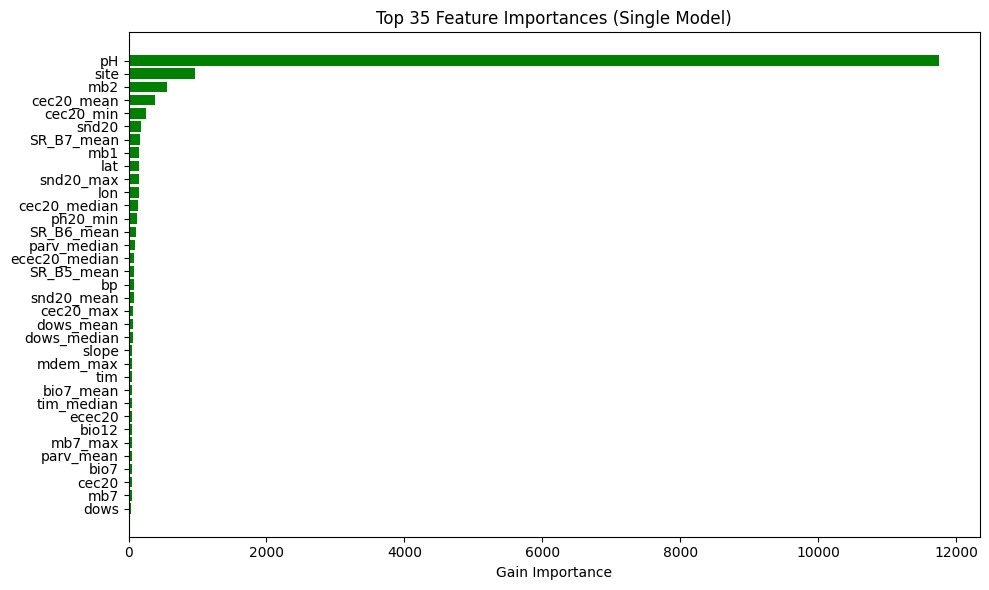

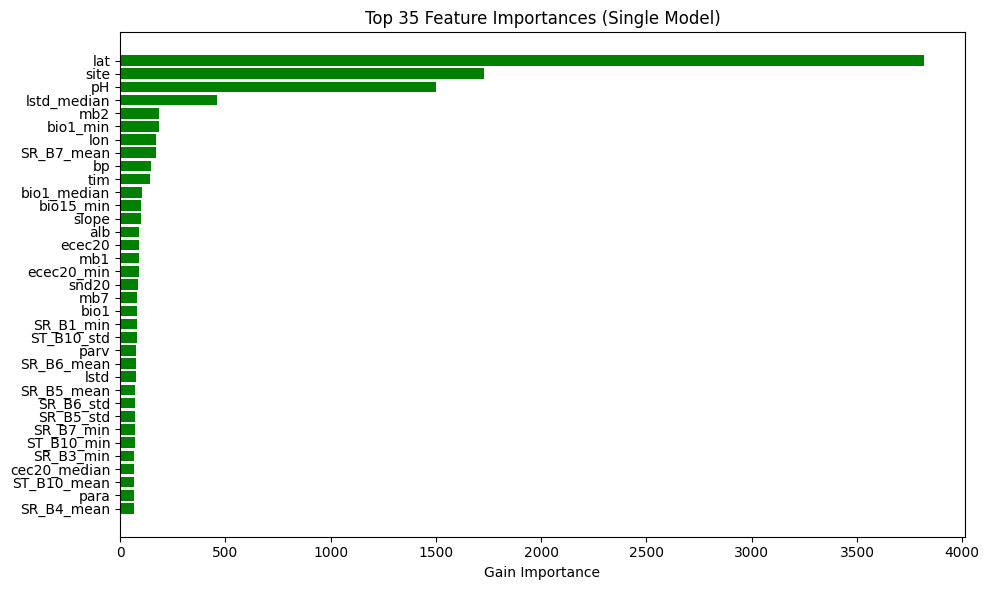

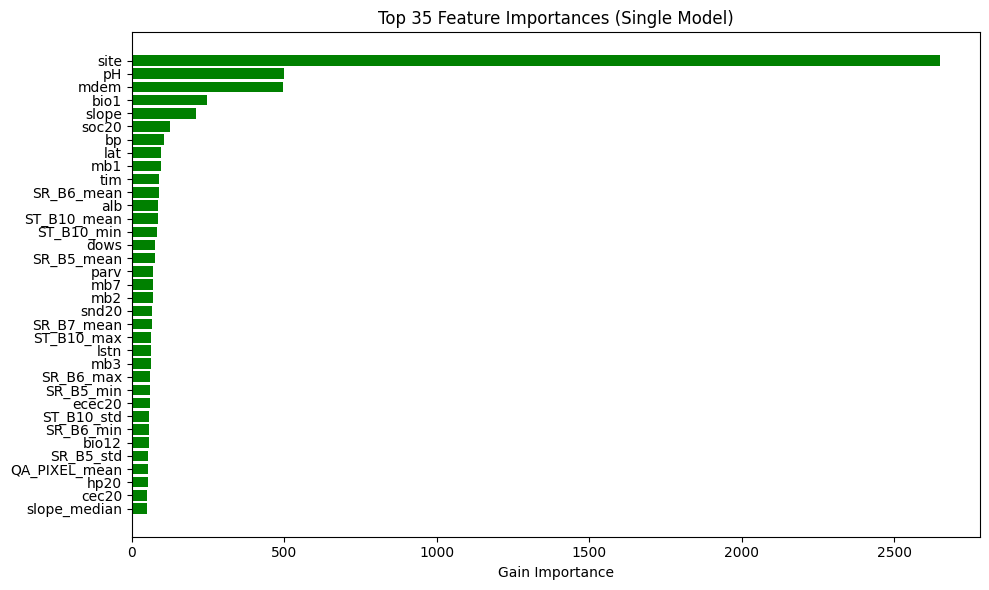

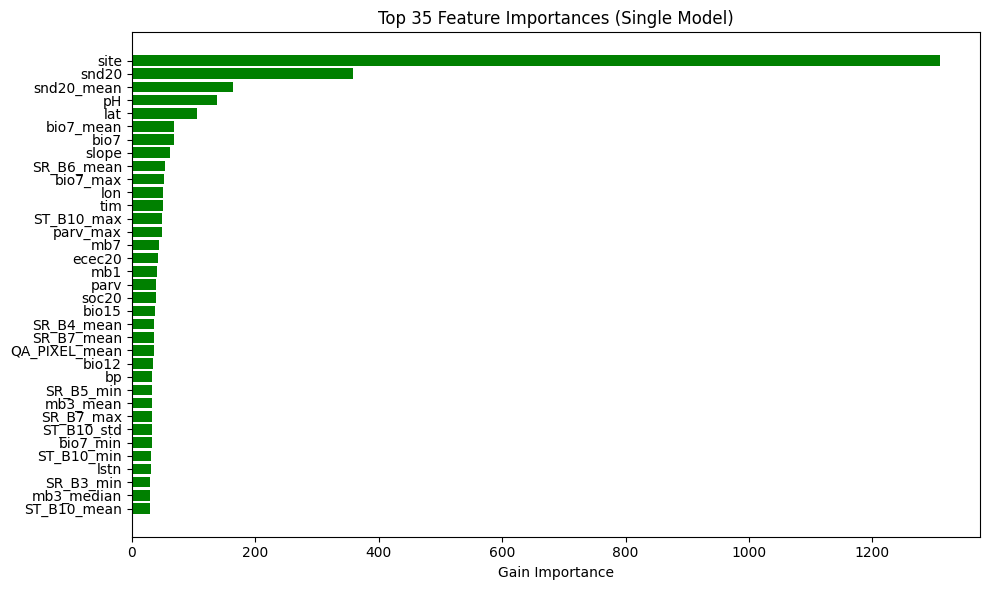

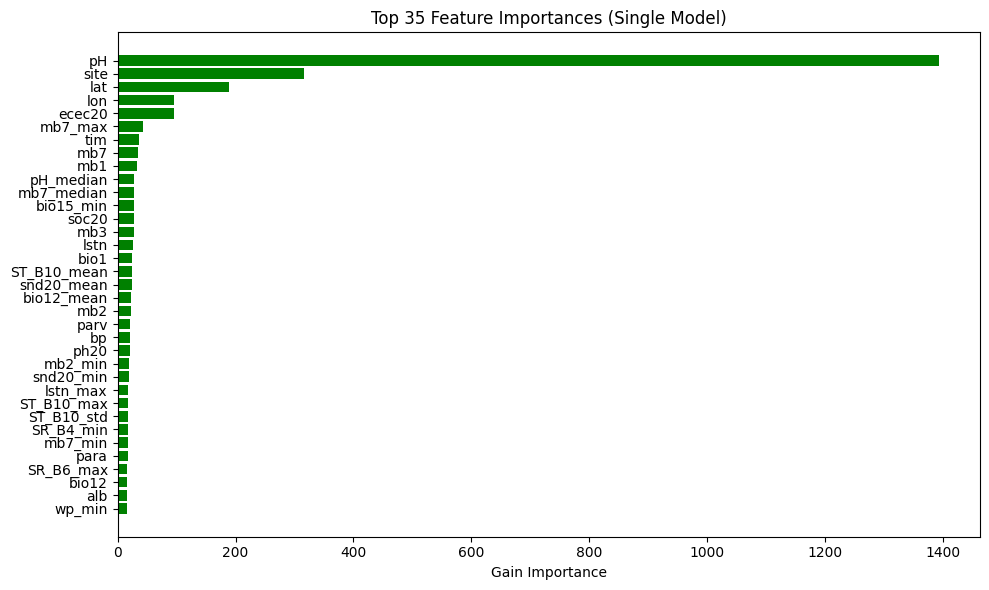

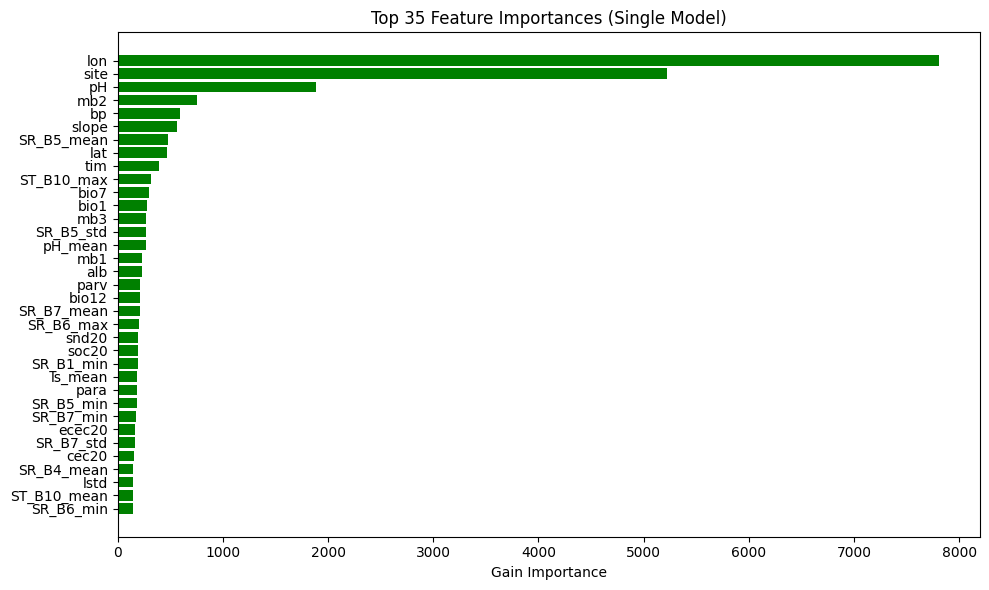

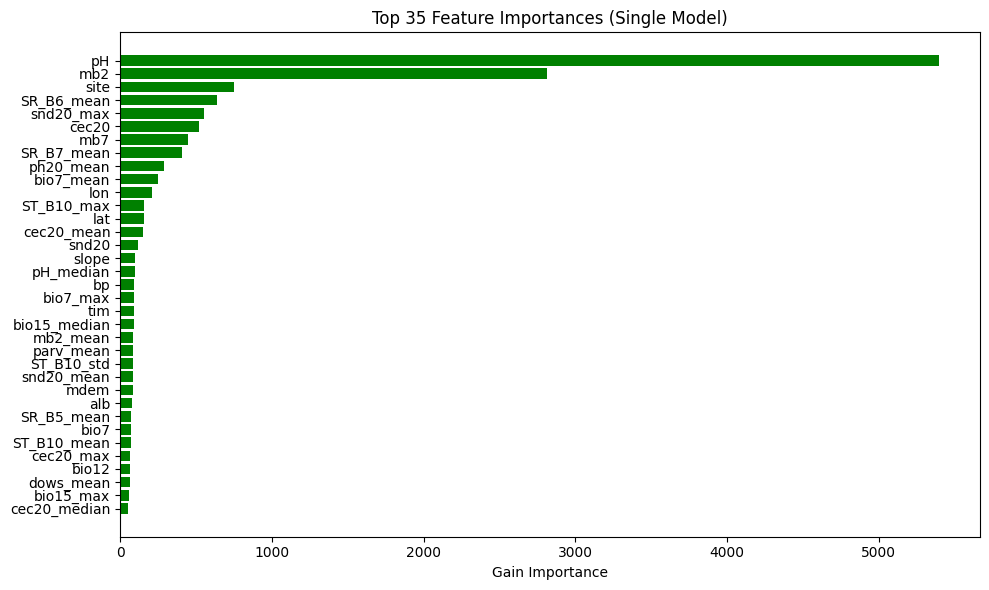

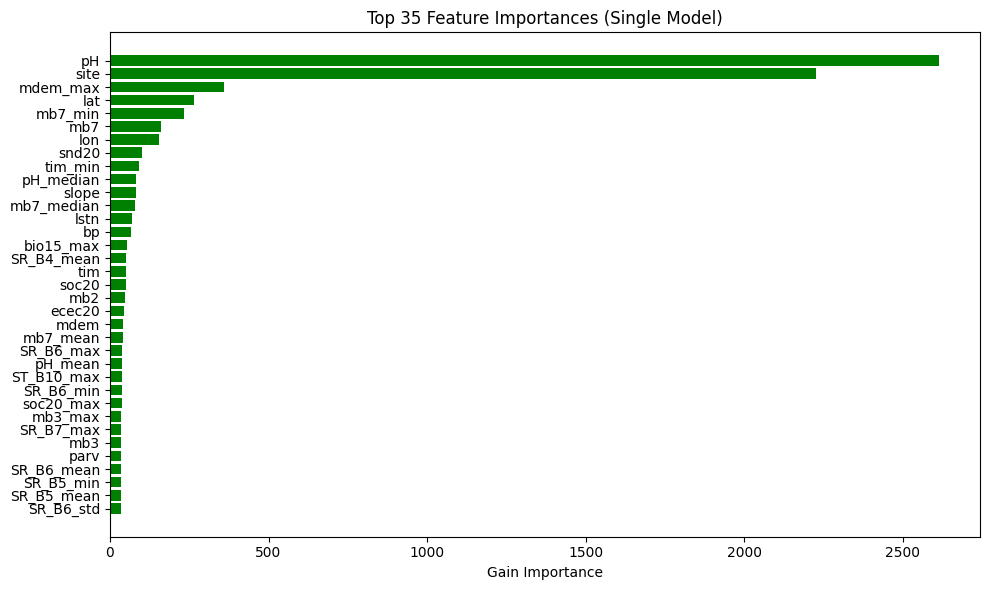

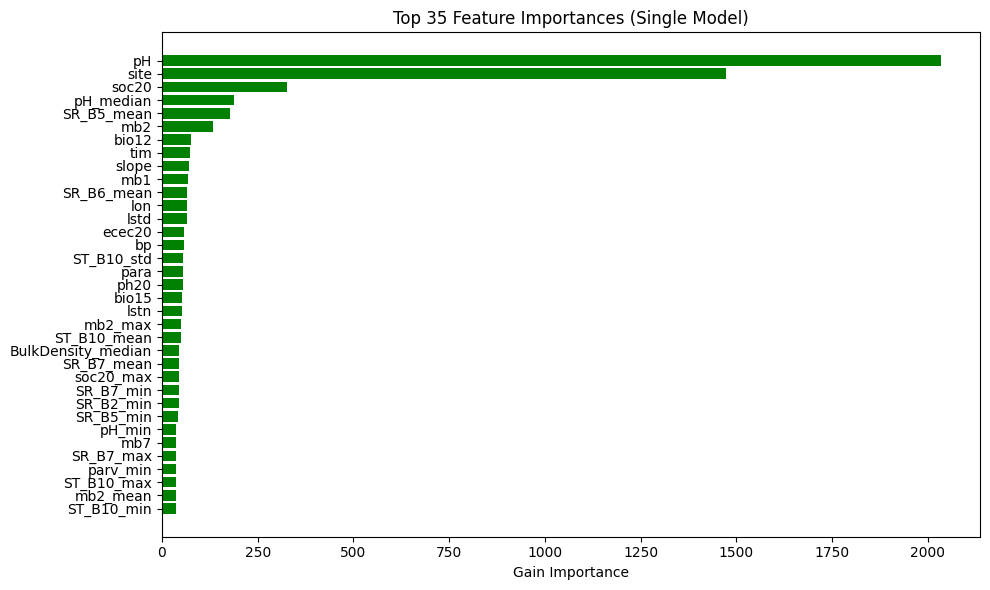

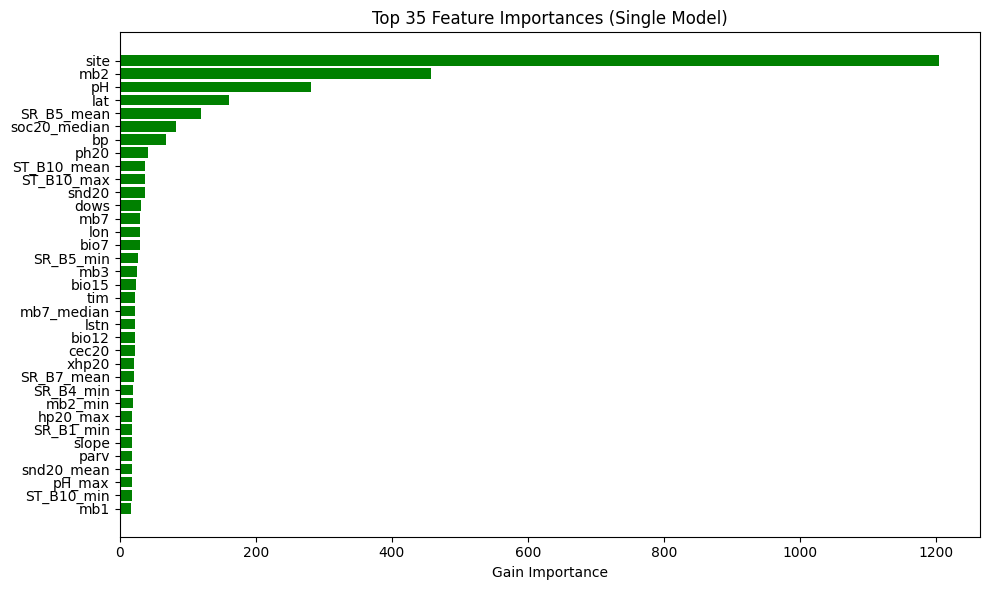

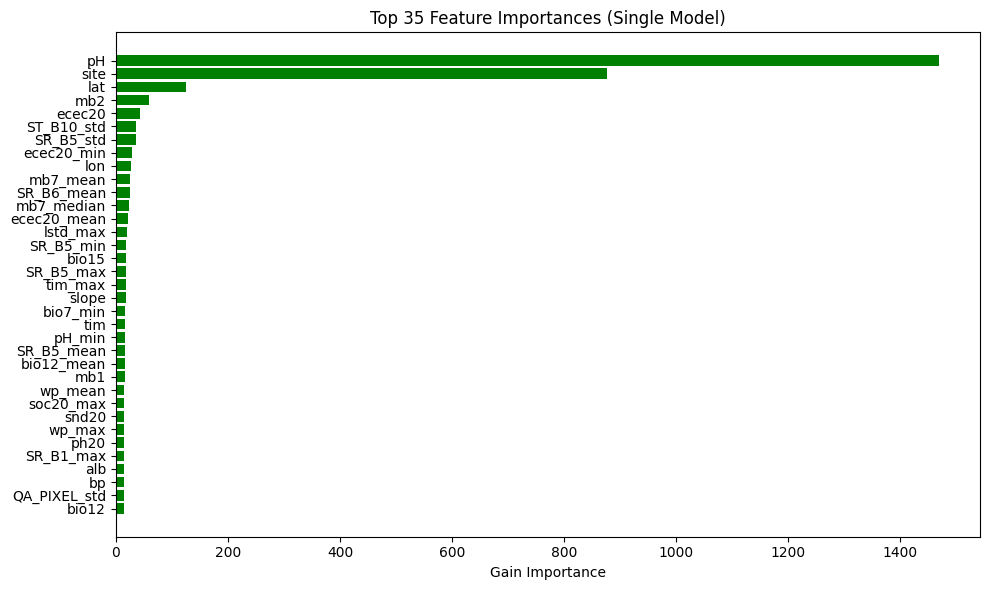

In [29]:
plot_single_model_importance(models_dict['ca'][2], X.columns, top_n=35)
plot_single_model_importance(models_dict['k'][2], X.columns, top_n=35)
plot_single_model_importance(models_dict['mn'][2], X.columns, top_n=35)
plot_single_model_importance(models_dict['cu'][2], X.columns, top_n=35)
plot_single_model_importance(models_dict['b'][2], X.columns, top_n=35)
plot_single_model_importance(models_dict['p'][2], X.columns, top_n=35)
plot_single_model_importance(models_dict['mg'][2], X.columns, top_n=35)
plot_single_model_importance(models_dict['fe'][2], X.columns, top_n=35)
plot_single_model_importance(models_dict['n'][2], X.columns, top_n=35)
plot_single_model_importance(models_dict['zn'][2], X.columns, top_n=35)
plot_single_model_importance(models_dict['s'][2], X.columns, top_n=35)

## 🧠 Extract Trained Models by Target

After cross-validation, the trained LightGBM models for each nutrient are stored in the `models_dict` dictionary. The following lines extract the list of trained models (one per fold) for each nutrient and assign them to individual variables for easier access and further analysis or prediction.

```python
models_n  = models_dict['n']
models_p  = models_dict['p']
models_k  = models_dict['k']
models_ca = models_dict['ca']
models_mg = models_dict['mg']
models_s  = models_dict['s']
models_fe = models_dict['fe']
models_mn = models_dict['mn']
models_zn = models_dict['zn']
models_cu = models_dict['cu']
models_b  = models_dict['b']
```

Each variable (e.g., `models_n`) holds a list of LightGBM models trained on that specific nutrient using K-Fold cross-validation.

---


In [30]:
models_n  = models_dict['n']
models_p  = models_dict['p']
models_k  = models_dict['k']
models_ca = models_dict['ca']
models_mg = models_dict['mg']
models_s  = models_dict['s']
models_fe = models_dict['fe']
models_mn = models_dict['mn']
models_zn = models_dict['zn']
models_cu = models_dict['cu']
models_b  = models_dict['b']

In [31]:
X_test.head()

,site,lon,lat,pH,alb,bio1,bio12,bio15,bio7,bp,cec20,dows,ecec20,hp20,ls,lstd,lstn,mb1,mb2,mb3,mb7,mdem,para,parv,ph20,slope,snd20,soc20,tim,xhp20,BulkDensity,pH_min,pH_max,pH_mean,pH_median,alb_min,alb_max,alb_mean,alb_median,bio1_min,bio1_max,bio1_mean,bio1_median,bio12_min,bio12_max,bio12_mean,bio12_median,bio15_min,bio15_max,bio15_mean,bio15_median,bio7_min,bio7_max,bio7_mean,bio7_median,bp_min,bp_max,bp_mean,bp_median,cec20_min,cec20_max,cec20_mean,cec20_median,dows_min,dows_max,dows_mean,dows_median,ecec20_min,ecec20_max,ecec20_mean,ecec20_median,hp20_min,hp20_max,hp20_mean,hp20_median,ls_min,ls_max,ls_mean,ls_median,lstd_min,lstd_max,lstd_mean,lstd_median,lstn_min,lstn_max,lstn_mean,lstn_median,mb1_min,mb1_max,mb1_mean,mb1_median,mb2_min,mb2_max,mb2_mean,mb2_median,mb3_min,mb3_max,mb3_mean,mb3_median,mb7_min,mb7_max,mb7_mean,mb7_median,mdem_min,mdem_max,mdem_mean,mdem_median,para_min,para_max,para_mean,para_median,parv_min,parv_max,parv_mean,parv_median,ph20_min,ph20_max,ph20_mean,ph20_median,slope_min,slope_max,slope_mean,slope_median,snd20_min,snd20_max,snd20_mean,snd20_median,soc20_min,soc20_max,soc20_mean,soc20_median,tim_min,tim_max,tim_mean,tim_median,wp_min,wp_max,wp_mean,wp_median,xhp20_min,xhp20_max,xhp20_mean,xhp20_median,BulkDensity_min,BulkDensity_max,BulkDensity_mean,BulkDensity_median,QA_PIXEL_mean,QA_PIXEL_std,QA_PIXEL_min,QA_PIXEL_max,QA_RADSAT_mean,QA_RADSAT_std,QA_RADSAT_min,QA_RADSAT_max,SR_B1_mean,SR_B1_std,SR_B1_min,SR_B1_max,SR_B2_mean,SR_B2_std,SR_B2_min,SR_B2_max,SR_B3_mean,SR_B3_std,SR_B3_min,SR_B3_max,SR_B4_mean,SR_B4_std,SR_B4_min,SR_B4_max,SR_B5_mean,SR_B5_std,SR_B5_min,SR_B5_max,SR_B6_mean,SR_B6_std,SR_B6_min,SR_B6_max,SR_B7_mean,SR_B7_std,SR_B7_min,SR_B7_max,ST_B10_mean,ST_B10_std,ST_B10_min,ST_B10_max
0,site_id_hgJpkz,69.170794,44.522885,6.86,144,256,910,108,186,0.038132,44.75,1.581062,17.099701,0.0997,0.03,40.674942,18.333445,991.000061,2484.000488,486.000031,1413.000244,817,37.940418,467.619293,6.825,1.056416,25.50,15.25,8.732471,0.005831,1.20,6.86,7.27,7.125000,7.185,139,144,141.500000,141.5,252,256,254.000000,254.0,910,1142,1021.500000,1017.0,108,110,109.000000,109.0,185,186,185.75,186.0,0.034111,0.071103,0.050398,0.048190,42.25,52.0,46.625,46.125,1.457660,5.482658,2.882902,2.295646,17.015301,21.152000,18.330776,17.577901,0.0153,0.152,0.080775,0.0779,0.03,0.030000,0.030000,0.030000,39.160236,40.674942,39.811288,39.704987,18.007334,18.333445,18.228101,18.285812,825.999939,991.000061,891.500000,874.500000,2374.000244,2484.000488,2428.000427,2427.000488,407.000000,486.000031,449.000015,451.500015,1238.000000,1413.000244,1322.250061,1319.000000,817,870,837.250000,831.0,37.940418,42.647343,40.499194,40.704508,404.839844,472.334045,440.700142,442.813339,6.725,6.825,6.768750,6.7625,0.962974,1.433321,1.108144,1.018141,22.00,26.00,24.375000,24.75,15.25,18.00,17.187500,17.75,8.732471,11.439353,10.057749,10.029587,0.016981,0.035683,0.026470,0.026608,0.000899,0.007186,0.004256,0.004469,1.20,1.25,1.2275,1.23,25359.955224,10159.910930,21824,55052,0.0,0.0,0,0,0.080165,0.128953,-0.083867,0.894473,0.096425,0.124520,0.004105,0.884848,0.138135,0.116921,0.039442,0.847668,0.154674,0.117727,0.034877,0.835705,0.297082,0.106241,0.168417,0.830480,0.263856,0.073856,0.091143,0.528998,0.190497,0.072419,0.050360,0.454005,1.077676,0.197278,0.505402,1.300812
1,site_id_olmuI5,68.885265,44.741057,7.08,129,260,851,110,187,0.040187,53.00,5.700576,25.129000,0.1290,0.03,41.836205,18.762138,819.000000,2257.000000,412.000000,1199.000122,759,35.961353,542.590149,6.725,0.730379,18.75,14.00,10.565657,0.005134,1.24,7.08,7.74,7.343333,7.210,129,131,129.666667,129.0,260,261,260.666667,261.0,841,851,846.333333,847.0,110,111,110.666667,111.0,187,187,187.00,187.0,0.040187,0.075281,0.053398,0.044726,53.00,60.0,56.000,55.000,4.160606,5.700576,4.889923,4.808586,25.129000,42.051498,34.082666,35.067501,0.0515,0.129,0.082667,0.0675,0.03,0.071170,0.043723,0.030000,41.836205,42.037308,41.922905,41.895203,18.762138,18.844263,18.810220,18.8242

## 📈 Generate Final Predictions from Cross-Validated Models

This section defines a function to aggregate predictions from multiple LightGBM models (trained via cross-validation) and computes the final predictions for each soil nutrient on the test set.

---

### 🔧 Function: `get_mean_prediction`

Aggregates predictions across folds for a given target.

* **Parameters:**

  * `models` *(list)*: List of trained LightGBM models for a target.
  * `X` *(pd.DataFrame)*: Test feature matrix.
* **Returns:**

  * Median prediction per sample across all models (more robust than mean to outliers).

```python
def get_mean_prediction(models, X):
    preds = np.array([model.predict(X) for model in models])
    return np.median(preds, axis=0)
```

---

### 🧪 Inference on Test Set

* Predictions are made for each target using the corresponding trained models.
* `np.expm1()` is used to reverse the earlier `log1p` transformation.
* Light postprocessing adjustments are applied:

  * `N` predictions are scaled by `0.95`
  * `Ca` predictions are scaled by `1.05`

```python
N_pred  = np.expm1(get_mean_prediction(models_n, X_test)) * 0.95
P_pred  = np.expm1(get_mean_prediction(models_p, X_test))
K_pred  = np.expm1(get_mean_prediction(models_k, X_test))
Ca_pred = np.expm1(get_mean_prediction(models_ca, X_test)) * 1.05
Mg_pred = np.expm1(get_mean_prediction(models_mg, X_test))
S_pred  = np.expm1(get_mean_prediction(models_s, X_test))
Fe_pred = np.expm1(get_mean_prediction(models_fe, X_test))
Mn_pred = np.expm1(get_mean_prediction(models_mn, X_test))
Zn_pred = np.expm1(get_mean_prediction(models_zn, X_test))
Cu_pred = np.expm1(get_mean_prediction(models_cu, X_test))
B_pred  = get_mean_prediction(models_b, X_test)  # No log transform was applied
```

---

### 📝 Notes

* **Median aggregation** helps reduce the impact of outlier predictions from individual folds.
* **Postprocessing adjustments** (e.g., scaling `Ca` and `N`) may help correct for consistent biases observed during validation.

---


In [32]:
# Function to get mean prediction from list of models
def get_mean_prediction(models, X):
    preds = np.array([model.predict(X) for model in models])
    # return preds.mean(axis=0)
    return np.median(preds, axis=0)

In [33]:
# Get averaged predictions for each target
N_pred  = np.expm1(get_mean_prediction(models_n, X_test)) * 0.95
P_pred  = np.expm1(get_mean_prediction(models_p, X_test))
K_pred  = np.expm1(get_mean_prediction(models_k, X_test))
Ca_pred = np.expm1(get_mean_prediction(models_ca, X_test)) * 1.05
Mg_pred = np.expm1(get_mean_prediction(models_mg, X_test))
S_pred  = np.expm1(get_mean_prediction(models_s, X_test))
Fe_pred = np.expm1(get_mean_prediction(models_fe, X_test))
Mn_pred = np.expm1(get_mean_prediction(models_mn, X_test))
Zn_pred = np.expm1(get_mean_prediction(models_zn, X_test))
Cu_pred = np.expm1(get_mean_prediction(models_cu, X_test))
B_pred  = get_mean_prediction(models_b, X_test)

The rest follows the same steps in the previous notebooks. Nice right?😜

In [34]:
submission = pd.DataFrame({'PID': test_df['PID'], 'N': N_pred, 'P': P_pred, 'K': K_pred, 'Ca': Ca_pred, 'Mg': Mg_pred, 'S': S_pred, 'Fe': Fe_pred, 'Mn': Mn_pred, 'Zn': Zn_pred, 'Cu': Cu_pred, 'B': B_pred})
submission.head()

,PID,N,P,K,Ca,Mg,S,Fe,Mn,Zn,Cu,B
0,ID_NGS9Bx,1409.258572,2.365517,119.254133,5229.419498,1508.339829,8.559882,106.720628,122.094763,1.330432,3.816012,0.201763
1,ID_YdVKXw,1096.884503,2.551894,146.377801,6506.849613,1760.869499,8.950145,101.807773,117.671599,1.325829,3.441509,0.217252
2,ID_MZAlfE,1433.594638,1.543390,140.312723,4847.412329,1972.447038,9.296575,114.634025,118.146496,1.312117,3.657955,0.184371
3,ID_GwCCMN,1395.587562,2.414319,140.972375,5619.525986,1452.780622,8.705632,117.887776,136.467001,1.457287,3.390436,0.208860
4,ID_K8sowf,1575.008855,2.553834,139.198966,4544.082557,1599.309449,8.711371,138.266609,134.944046,1.572114,3.894573,0.203319


In [35]:
# prompt: turn submission into a 3 column file that has the column PID, Nutrient, Value

submission_melted = submission.melt(id_vars=['PID'], var_name='Nutrient', value_name='Available_Nutrients_in_ppm')
submission_melted = submission_melted.sort_values('PID')
submission_melted.head()

,PID,Nutrient,Available_Nutrients_in_ppm
19869,ID_002W8m,Zn,2.364304
15033,ID_002W8m,Fe,127.121372
2943,ID_002W8m,P,2.763589
24705,ID_002W8m,B,0.323135
525,ID_002W8m,N,2007.354872


In [36]:
# prompt: merge test_gap_df with submission_melted on PID and Nutrient
nutrient_df = pd.merge(test_gap_df, submission_melted, on=['PID', 'Nutrient'], how='left')

In [37]:
nutrient_df

,Nutrient,Required,PID,BulkDensity,Available_Nutrients_in_ppm
0,N,100.00,ID_NGS9Bx,1.20,1409.258572
1,P,40.00,ID_NGS9Bx,1.20,2.365517
2,K,52.00,ID_NGS9Bx,1.20,119.254133
3,Ca,12.00,ID_NGS9Bx,1.20,5229.419498
4,Mg,8.00,ID_NGS9Bx,1.20,1508.339829
...,...,...,...,...,...
26593,Fe,0.80,ID_oMn2Yb,1.14,156.794643
26594,Mn,0.40,ID_oMn2Yb,1.14,142.940343
26595,Zn,0.40,ID_oMn2Yb,1.14,4.080074
26596,Cu,0.20,ID_oMn2Yb,1.14,1.806147


In [38]:
test_gap_df

,Nutrient,Required,PID,BulkDensity
0,N,100.00,ID_NGS9Bx,1.20
1,P,40.00,ID_NGS9Bx,1.20
2,K,52.00,ID_NGS9Bx,1.20
3,Ca,12.00,ID_NGS9Bx,1.20
4,Mg,8.00,ID_NGS9Bx,1.20
...,...,...,...,...
26593,Fe,0.80,ID_oMn2Yb,1.14
26594,Mn,0.40,ID_oMn2Yb,1.14
26595,Zn,0.40,ID_oMn2Yb,1.14
26596,Cu,0.20,ID_oMn2Yb,1.14


In [39]:
soil_depth = 20  # cm

# Calculate the Available_Nutrients_in_kg_ha
nutrient_df['Available_Nutrients_in_kg_ha'] = (nutrient_df['Available_Nutrients_in_ppm']
                                               * soil_depth * nutrient_df['BulkDensity'] * 0.1)

In [40]:
nutrient_df.head()

,Nutrient,Required,PID,BulkDensity,Available_Nutrients_in_ppm,Available_Nutrients_in_kg_ha
0,N,100.0,ID_NGS9Bx,1.2,1409.258572,3382.220573
1,P,40.0,ID_NGS9Bx,1.2,2.365517,5.677242
2,K,52.0,ID_NGS9Bx,1.2,119.254133,286.209918
3,Ca,12.0,ID_NGS9Bx,1.2,5229.419498,12550.606794
4,Mg,8.0,ID_NGS9Bx,1.2,1508.339829,3620.015590


In [41]:
nutrient_df["Gap"] = nutrient_df["Required"] - nutrient_df["Available_Nutrients_in_kg_ha"]
nutrient_df['ID'] = nutrient_df['PID'] + "_" + nutrient_df['Nutrient']
nutrient_df = nutrient_df[['ID', 'Gap']]
nutrient_df.head()

,ID,Gap
0,ID_NGS9Bx_N,-3282.220573
1,ID_NGS9Bx_P,34.322758
2,ID_NGS9Bx_K,-234.209918
3,ID_NGS9Bx_Ca,-12538.606794
4,ID_NGS9Bx_Mg,-3612.015590


In [42]:
nutrient_df.to_csv('lgbm_submission_log.csv', index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv


Now Let's put the nail on the coffin. The last notebook is quite the loaded one😪 but do not worry, it is worth it.

Let's move to the next notebook!